In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from IPython.display import display, Math
from enum import *

In [2]:
#Se controla por medio de estados la clasificacion de todas las muestras de una clase dada
class EstadosClasificacion(Enum):
    estado1 = "Todas las muestras de la clase 1 están efectivamente en la clase 1"
    estado2 = "Todas las muestras de la clase 2 están efectivamente en la clase 2"
    estado3 = "Se tiene al menos una muestra en la clase equivocada"

def printColouredText(text, foregroundColor = (0, 0, 0), backgroundColor = (255, 255, 255)):
    return "\033[48;2;{};{};{}m\033[38;2;{};{};{}m{}\033[38;2;0;0;0m\033[48;2;255;255;255m".format(backgroundColor[0], backgroundColor[1], backgroundColor[2], foregroundColor[0], foregroundColor[1], foregroundColor[2], text)

#La distancia con signo (ignorando el valor absoluto involucrado en la formula de distancia de un punto a un hiperplano) permite saber la distancia ademas de si el punto se encuentra por encima o por debajo del hiperplano
def calcularDistanciaConSignoPuntoAHiperplano(listaCoeficientesCompletosHiperplanoSeparacion, puntoMuestra, numeroDimensiones):
    return (np.dot(listaCoeficientesCompletosHiperplanoSeparacion[0:numeroDimensiones], puntoMuestra) + listaCoeficientesCompletosHiperplanoSeparacion[numeroDimensiones]) / np.linalg.norm(listaCoeficientesCompletosHiperplanoSeparacion[0:numeroDimensiones])

def evaluarPuntoRespectoAHiperplano(listaCoeficientesCompletosHiperplanoSeparacion, puntoMuestra, numeroDimensiones):
    return np.dot(listaCoeficientesCompletosHiperplanoSeparacion[0:numeroDimensiones], puntoMuestra) + listaCoeficientesCompletosHiperplanoSeparacion[numeroDimensiones]

def verificarMuestrasClasificadasEnUnaSolaClase(muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClaseObjetivo, listaCoeficientesCompletosHiperplano, numeroDimensiones):
    clasePuntoActual = nombreClaseObjetivo
    clasePuntoAnterior = nombreClaseObjetivo
    for punto in muestraPuntosPorClases[nombreClaseObjetivo]:
        clasePuntoAnterior = clasePuntoActual
        valorPunto = evaluarPuntoRespectoAHiperplano(listaCoeficientesCompletosHiperplano, punto, numeroDimensiones)
        if valorPunto == 0.0:
            return EstadosClasificacion.estado3
        elif np.sign(valorPunto) == 1.0:
            clasePuntoActual = nombreClase1
        else:
            clasePuntoActual = nombreClase2
        if clasePuntoActual != clasePuntoAnterior:
            return EstadosClasificacion.estado3
    
    if clasePuntoActual == nombreClase1:
        return EstadosClasificacion.estado1
    elif clasePuntoActual == nombreClase2:
        return EstadosClasificacion.estado2
    return EstadosClasificacion.estado3

def obtenerListasCoordenadasRespectivas(listaPuntos, numeroDimensiones):
    diccionarioPuntosPorCoordenadas = {}
    for indice in range(numeroDimensiones):
        diccionarioPuntosPorCoordenadas[indice] = []
        
    for puntoActual in listaPuntos:
        for indice in range(numeroDimensiones):
            coordenadaActual = puntoActual[indice]
            diccionarioPuntosPorCoordenadas[indice].append(coordenadaActual)
    return diccionarioPuntosPorCoordenadas

In [3]:
#Parametros de ejecucion del programa
nombreArchivoInformacion = "InformacionEjercicioClasificacion.txt"
nombreArchivoDataset = "DatasetClasificacion.csv"
tasaAprendizaje = 0.001
tiempoPausaAnimacion = 0.01

colorTextoVerde = (35, 155, 86)
colorTextoRojo = (176, 58, 46)

In [4]:
numeroDimensiones = None
nombreClase1 = None
nombreClase2 = None
listaCoeficientesHiperplanoBase = []
etiquetaCoordenadaPuntos = None
nombreColumnaClaseAsignada = None

inputStream = open(nombreArchivoInformacion, "r")
lineasTextoArchivo = inputStream.readlines()
for numeroLineaActual in range(len(lineasTextoArchivo)):
    if numeroLineaActual == 0:
        numeroDimensiones = int(lineasTextoArchivo[numeroLineaActual].strip())
    elif numeroLineaActual == 1:
        nombreClase1 = lineasTextoArchivo[numeroLineaActual].strip()
    elif numeroLineaActual == 2:
        nombreClase2 = lineasTextoArchivo[numeroLineaActual].strip()
    elif numeroLineaActual == 3:
        lineaTextoActual = lineasTextoArchivo[numeroLineaActual].strip()
        lineaTextoActual = lineaTextoActual[1:(len(lineaTextoActual) - 1)]
        datosCoeficientesHiperplano = lineaTextoActual.split(", ")
        for coeficiente in datosCoeficientesHiperplano:
            listaCoeficientesHiperplanoBase.append(float(coeficiente))
    elif numeroLineaActual == 4:
        etiquetaCoordenadaPuntos = lineasTextoArchivo[numeroLineaActual].strip()
    elif numeroLineaActual == 5:
        nombreColumnaClaseAsignada = lineasTextoArchivo[numeroLineaActual].strip()
inputStream.close()

print("Se ha extraído la información del archivo", printColouredText(nombreArchivoInformacion, colorTextoVerde))
print("Se está trabajando sobre", printColouredText(str(numeroDimensiones) + " dimension(es)", colorTextoVerde))
print("Los coeficientes del plano sobre el cual se generó del dataset de puntos para clasificación son:", printColouredText(str(listaCoeficientesHiperplanoBase), colorTextoRojo))

Se ha extraído la información del archivo InformacionEjercicioClasificacion.txt
Se está trabajando sobre 3 dimension(es)
Los coeficientes del plano sobre el cual se generó del dataset de puntos para clasificación son: [-0.39769888183484237, 0.08470121178642387, 0.29091995194964326, 0.16554139588090022]


In [5]:
datasetFile = pd.read_csv(nombreArchivoDataset)

listaPuntosMuestra = []
muestraPuntosPorClases = {nombreClase1: [], nombreClase2: []}
for indicefilaActual, filaActual in datasetFile.iterrows():
    puntoActual = []
    for indice in range(numeroDimensiones):
        nombreColumnaActual = "Coordenada $" + etiquetaCoordenadaPuntos + "_{" + str(indice + 1) + "}$"
        puntoActual.append(filaActual[nombreColumnaActual])
    categoriaPuntoActual = filaActual[nombreColumnaClaseAsignada]
    listaPuntosMuestra.append(puntoActual)
    muestraPuntosPorClases[categoriaPuntoActual].append(puntoActual)

print("Se ha extraído la información del archivo", printColouredText(nombreArchivoDataset, colorTextoVerde))
print("Se tiene un total de", printColouredText(str(len(listaPuntosMuestra)) + " punto(s)", colorTextoVerde))
print("De la clase", printColouredText(nombreClase1, colorTextoRojo), "se tienen", printColouredText(str(len(muestraPuntosPorClases[nombreClase1])) + " punto(s)", colorTextoRojo))
print("De la clase", printColouredText(nombreClase2, colorTextoRojo), "se tienen", printColouredText(str(len(muestraPuntosPorClases[nombreClase2])) + " punto(s)", colorTextoRojo))

Se ha extraído la información del archivo DatasetClasificacion.csv
Se tiene un total de 100 punto(s)
De la clase Clase 1 se tienen 50 punto(s)
De la clase Clase 2 se tienen 50 punto(s)


In [6]:
#Este bloque de codigo se puede comentar para que no se proponga inicialmente un hiperplano de coeficientes aleatorios sino para que el hiperplano propuesto inicialmente separe perfectamente las muestras de las 2 clases y por lo tanto no se ejecuta el algoritmo del perceptron simple
listaCoeficientesHiperplanoBase = list(np.random.uniform(low = -1.0, high = 1.0, size = numeroDimensiones + 1))
while listaCoeficientesHiperplanoBase[0:numeroDimensiones] == [0] * numeroDimensiones:
    listaCoeficientesHiperplanoBase = list(np.random.uniform(low = -1.0, high = 1.0, size = numeroDimensiones + 1))

<IPython.core.display.Javascript object>


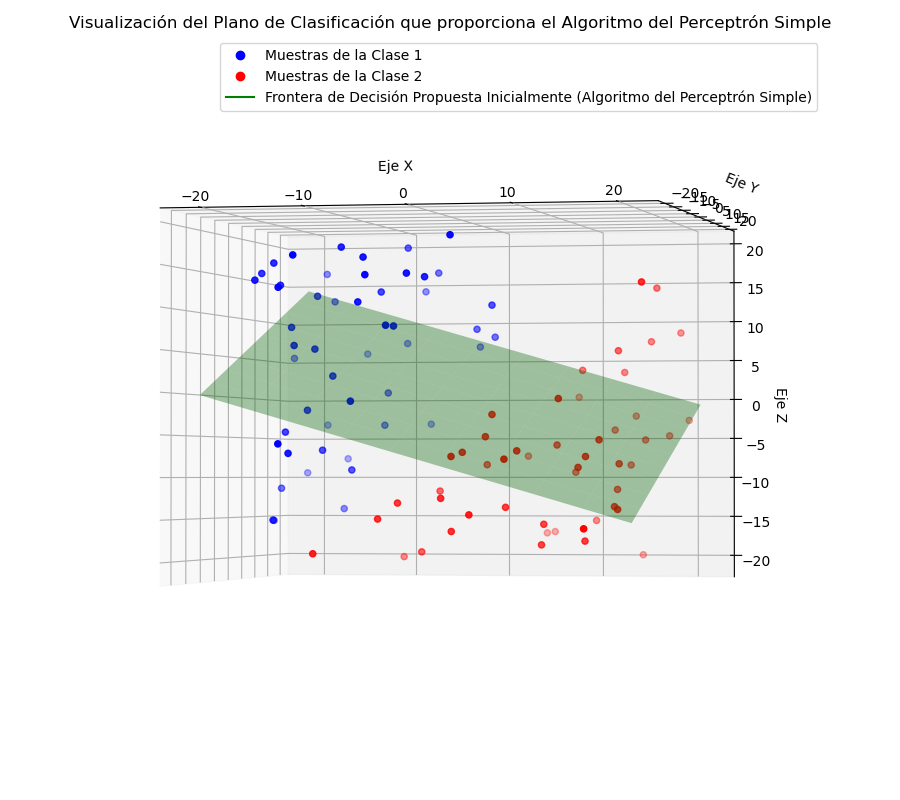

/tmp/ipykernel_25658/242376291.py:81: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = currentFigure.gca(projection = '3d')


In [7]:
%matplotlib notebook

listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
valoresCoordenadasYPuntosClase1 = None
valoresCoordenadasYPuntosClase2 = None
valoresCoordenadasZPuntosClase1 = None
valoresCoordenadasZPuntosClase2 = None
minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1
minimoEjeY = None
maximoEjeY = None
minimoEjeZ = None
maximoEjeZ = None

numeroMuestrasHiperplanoClasificacion = 10
if numeroDimensiones == 1:
    valoresCoordenadasYPuntosClase1 = [0.0] * len(listaPuntosClase1PorCoordenadasRespectivas[0])
    valoresCoordenadasYPuntosClase2 = [0.0] * len(listaPuntosClase2PorCoordenadasRespectivas[0])
    
    plt.figure(num = 1, figsize = (9, 3))
    plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
    plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
    plt.axvline(x = -listaCoeficientesHiperplanoBase[numeroDimensiones] / listaCoeficientesHiperplanoBase[numeroDimensiones - 1], color = 'g', linestyle = '-', label = "Frontera de Decisión Propuesta Inicialmente (Algoritmo del Perceptrón Simple)", linewidth = 2.5)
    plt.legend(loc = 'upper left')
    plt.xlabel("Eje X")
    plt.ylabel("")
    plt.gca().get_yaxis().set_visible(False)
    plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    plt.grid(True)
    plt.show()
elif numeroDimensiones == 2:
    valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
    valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
    minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
    maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1
    
    listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
    if listaCoeficientesHiperplanoBase[numeroDimensiones - 1] != 0.0:
        listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesHiperplanoBase[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesHiperplanoBase[numeroDimensiones]) / listaCoeficientesHiperplanoBase[numeroDimensiones - 1]
    elif listaCoeficientesHiperplanoBase[numeroDimensiones - 2] != 0.0:
        listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesHiperplanoBase[numeroDimensiones] / listaCoeficientesHiperplanoBase[numeroDimensiones - 2]] * numeroMuestrasHiperplanoClasificacion

    plt.figure(num = 1, figsize = (9, 8))
    plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
    plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
    plt.plot(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, 'g-', label = "Frontera de Decisión Propuesta Inicialmente (Algoritmo del Perceptrón Simple)")
    plt.legend(loc = 'upper left')
    plt.xlabel("Eje X")
    plt.ylabel("Eje Y")
    plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    plt.grid(True)
    plt.show()
elif numeroDimensiones == 3:
    valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
    valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
    valoresCoordenadasZPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[2]
    valoresCoordenadasZPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[2]
    minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
    maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1
    minimoEjeZ = np.min(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) - 1
    maximoEjeZ = np.max(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) + 1

    listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaZHiperplanoBase = np.linspace(minimoEjeZ, maximoEjeZ, num = numeroMuestrasHiperplanoClasificacion)
    if listaCoeficientesHiperplanoBase[numeroDimensiones - 1] != 0.0:
        listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase)
        listaValoresCoordenadaZHiperplanoBase = -(listaCoeficientesHiperplanoBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesHiperplanoBase[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoBase + listaCoeficientesHiperplanoBase[numeroDimensiones]) / listaCoeficientesHiperplanoBase[numeroDimensiones - 1]
    elif listaCoeficientesHiperplanoBase[numeroDimensiones - 2] != 0.0:
        listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
        listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesHiperplanoBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesHiperplanoBase[numeroDimensiones]) / listaCoeficientesHiperplanoBase[numeroDimensiones - 2]
    elif listaCoeficientesHiperplanoBase[numeroDimensiones - 3] != 0.0:
        listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
        listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesHiperplanoBase[numeroDimensiones] / listaCoeficientesHiperplanoBase[numeroDimensiones - 3]] * numeroMuestrasHiperplanoClasificacion
    
    currentFigure = plt.figure(num = 1, figsize = (9, 8))
    ax = currentFigure.gca(projection = '3d')
    ax.view_init(elev = 10, azim = -40)
    ax.scatter(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, valoresCoordenadasZPuntosClase1, c = 'b', marker = 'o')
    etiquetaLeyendaPuntosClase1 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'b', marker = 'o')
    ax.scatter(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, valoresCoordenadasZPuntosClase2, c = 'r', marker = 'o')
    etiquetaLeyendaPuntosClase2 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'r', marker = 'o')
    ax.plot_surface(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase, color = 'g', alpha = 0.35)
    etiquetaLeyendaPlano = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'g')
    ax.set_xlabel("Eje X")
    ax.set_ylabel("Eje Y")
    ax.set_zlabel("Eje Z")
    ax.set_title("Visualización del Plano de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    ax.legend([etiquetaLeyendaPuntosClase1, etiquetaLeyendaPuntosClase2, etiquetaLeyendaPlano], ["Muestras de la Clase 1", "Muestras de la Clase 2", "Frontera de Decisión Propuesta Inicialmente (Algoritmo del Perceptrón Simple)"], numpoints = 1)
    plt.tight_layout()
    plt.show()

In [8]:
def crearTextoEcuacionHiperplano(listaCoeficientesHiperplanoBase, numeroDimensiones):
    d = None
    ddd = {}
    for indice in range(numeroDimensiones + 1):
        if listaCoeficientesHiperplanoBase[indice] != 0.0:
            ddd[indice] = listaCoeficientesHiperplanoBase[indice]
    
    k = 0
    if numeroDimensiones <= 3:
        for indice in ddd.keys():
            if k == 0:
                d = r'{}'.format(ddd[indice]) + chr(120 + indice)
            elif k == len(ddd.keys()) - 1:
                if indice == numeroDimensiones:
                    if ddd[indice] > 0.0:
                        d += ' + {}'.format(ddd[indice])
                    elif ddd[indice] < 0.0:
                        d += ' - {}'.format(np.abs(ddd[indice]))
                else:
                    if ddd[indice] > 0.0:
                        d += ' + {}'.format(ddd[indice]) + chr(120 + indice)
                    elif ddd[indice] < 0.0:
                        d += ' - {}'.format(np.abs(ddd[indice])) + chr(120 + indice)
            else:
                if ddd[indice] > 0.0:
                    d += ' + {}'.format(ddd[indice]) + chr(120 + indice)
                elif ddd[indice] < 0.0:
                    d += ' - {}'.format(np.abs(ddd[indice])) + chr(120 + indice)
            k += 1
    d += ' = 0'
    return d
        
    """
    if numeroDimensiones <= 3:
        for indice in range(numeroDimensiones + 1):
            if indice == 0:
                d = r'{}'.format(listaCoeficientesHiperplanoBase[indice]) + chr(120 + indice)
            elif indice == numeroDimensiones:
                if listaCoeficientesHiperplanoBase[indice] > 0.0:
                    d += ' + {} = 0'.format(listaCoeficientesHiperplanoBase[indice])
                elif listaCoeficientesHiperplanoBase[indice] < 0.0:
                    d += ' - {} = 0'.format(np.abs(listaCoeficientesHiperplanoBase[indice]))
            else:
                if listaCoeficientesHiperplanoBase[indice] > 0.0:
                    d += ' + {}'.format(listaCoeficientesHiperplanoBase[indice]) + chr(120 + indice)
                elif listaCoeficientesHiperplanoBase[indice] < 0.0:
                    d += ' - {}'.format(np.abs(listaCoeficientesHiperplanoBase[indice])) + chr(120 + indice)
    else:
        for indice in range(numeroDimensiones + 1):
            if indice == 0:
                d = r'{}x'.format(listaCoeficientesHiperplanoBase[indice]) + '_{' + str(indice + 1) + '}'
            elif indice == numeroDimensiones:
                if listaCoeficientesHiperplanoBase[indice] > 0.0:
                    d += ' + {} = 0'.format(listaCoeficientesHiperplanoBase[indice])
                elif listaCoeficientesHiperplanoBase[indice] < 0.0:
                    d += ' - {} = 0'.format(np.abs(listaCoeficientesHiperplanoBase[indice]))
            else:
                if listaCoeficientesHiperplanoBase[indice] > 0.0:
                    d += ' + {}x'.format(listaCoeficientesHiperplanoBase[indice]) + '_{' + str(indice + 1) + '}'
                elif listaCoeficientesHiperplanoBase[indice] < 0.0:
                    d += ' - {}x'.format(np.abs(listaCoeficientesHiperplanoBase[indice])) + '_{' + str(indice + 1) + '}'
    """

#c = r'{}x '.format(listaCoeficientesHiperplanoBase[0])
#if listaCoeficientesHiperplanoBase[1] < 0.0:
#    c += ' - {}y '.format(np.abs(listaCoeficientesHiperplanoBase[1]))
#elif listaCoeficientesHiperplanoBase[1] > 0.0:
#    c += ' + {}y '.format(listaCoeficientesHiperplanoBase[1])
#if listaCoeficientesHiperplanoBase[2] < 0.0:
#    c += ' - {}z '.format(np.abs(listaCoeficientesHiperplanoBase[2]))
#elif listaCoeficientesHiperplanoBase[2] > 0.0:
#    c += ' + {}z '.format(listaCoeficientesHiperplanoBase[2])
#if listaCoeficientesHiperplanoBase[3] < 0.0:
#    c += ' - {} = 0'.format(np.abs(listaCoeficientesHiperplanoBase[3]))
#elif listaCoeficientesHiperplanoBase[3] > 0.0:
#    c += ' + {} = 0'.format(listaCoeficientesHiperplanoBase[3])

#for i in range(numeroDimensiones + 1):
#    if i == 0:
#        c = r'{}x '.format(listaCoeficientesHiperplanoBase[i])
#    else:
#        c += ' + {}x '.format(listaCoeficientesHiperplanoBase[i])

d = crearTextoEcuacionHiperplano(listaCoeficientesHiperplanoBase, numeroDimensiones)
ee = crearTextoEcuacionHiperplano([0, 0, 1, 0], numeroDimensiones)
ff = crearTextoEcuacionHiperplano([2, 0, 1, 0], numeroDimensiones)
gg = crearTextoEcuacionHiperplano([3, 5, 0, 0], numeroDimensiones)
kk = crearTextoEcuacionHiperplano([8, 0, 0, -9], numeroDimensiones)
ll = crearTextoEcuacionHiperplano([0, 4, 6, 11], numeroDimensiones)

#display(Math(c))
display(Math(d))
display(Math(ee))
display(Math(ff))
display(Math(gg))
display(Math(kk))
display(Math(ll))
#display(Math(r'Dims: {}x{}m \\ Area: {}m^2 \\ Volume: {}m^3'.format(a, round(b,2), P, V)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>